# 2D motion with a spinning phone

This is a hodgpodge of code that was used while debugging the rotation matrix. What is modeled is a phone that is moving linearly through 2-dimensional space. But the phone's heading is changing at a constant rate of 0.1pi rad/s. The kalman filter is effective at maintaining the position, but there appears to be an error with the rotation equations, since if the Kalman fitler is initialized to some angle other than the true angle, the IMU (unaided by the GNSS) wants to depart the opposite direction. In other words, turn the phone right, and it wants to go left.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

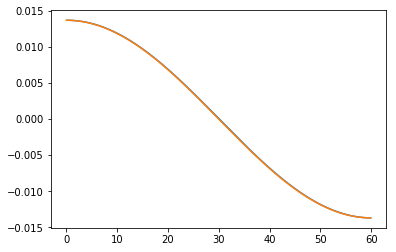

In [7]:
TOTAL_DISTANCE = 10 # meters 

TOTAL_SECONDS = 60 # seconds
SAMPLING_RATE = 10  # Hz
dt = 1 / SAMPLING_RATE

GPS_RMS_ERROR = 1 # meter
ACCELEROMETER_RMS_ERROR = 1000e-6*9.8 * np.sqrt(SAMPLING_RATE) # m/s**2
GYRO_RMS_ERROR = 1e-3 * np.sqrt(SAMPLING_RATE) #rad/s

number_of_timesteps = TOTAL_SECONDS * SAMPLING_RATE

t = np.arange(number_of_timesteps) / SAMPLING_RATE

true_acceleration = TOTAL_DISTANCE / 2 * np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS) ) * (2 * np.pi / (2 * TOTAL_SECONDS))**2
true_position = TOTAL_DISTANCE * ( 1 - np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS))) / 2
true_position = TOTAL_DISTANCE * np.sin(2*np.pi*t / (4*TOTAL_SECONDS))**2

plt.plot(t[2:], np.diff(np.diff(true_position)) / dt**2)
plt.plot(t, true_acceleration)

In [128]:
angle = 2*np.pi / 8
position_2d = np.zeros((len(true_position), 2))
position_2d[:, 0] = np.cos(angle) * true_position
position_2d[:, 1] = np.sin(angle) * true_position

rotation_rate = .1 * np.pi 
true_yaw = np.mod(np.pi + np.arange(len(t)) * rotation_rate * dt, 2*np.pi) - np.pi

In [129]:
acceleration_2d = np.zeros((len(true_acceleration), 2))
acceleration_2d[:, 0] = np.cos(angle) * true_acceleration
acceleration_2d[:, 1] = np.sin(angle) * true_acceleration

In [130]:
np.random.seed(52)
sensor_position = np.zeros((number_of_timesteps, 3))

sensor_position = np.nan * np.empty((number_of_timesteps, 3))
sensor_position_ = np.empty((number_of_timesteps, 3))

#sensor_position_ = true_position + np.random.randn(number_of_timesteps) * GPS_RMS_ERROR

sensor_position_[:, 0] = np.cos(angle) * true_position + np.random.randn(number_of_timesteps) * GPS_RMS_ERROR
sensor_position_[:, 1] = np.sin(angle) * true_position + np.random.randn(number_of_timesteps) * GPS_RMS_ERROR
sensor_position_[:, 2] = GPS_RMS_ERROR

sensor_position[::SAMPLING_RATE, :] = sensor_position_[::SAMPLING_RATE, :]


ax = np.cos(true_yaw) * acceleration_2d[:, 0] - np.sin(true_yaw) * acceleration_2d[:,1]
ay = np.sin(true_yaw) * acceleration_2d[:, 0] + np.cos(true_yaw) * acceleration_2d[:,1]

sensor_accelerometer = np.stack([ax, ay]).T + np.random.randn(number_of_timesteps, 2) * ACCELEROMETER_RMS_ERROR
sensor_gyro = rotation_rate + np.random.randn(*true_yaw.shape) * GYRO_RMS_ERROR

In [164]:
Q_pos = 0
Q_vel = .1
Q_ang = 1

number_of_states = 5

Q = np.array([
    [ACCELEROMETER_RMS_ERROR*dt**2/2, 0, 0, 0, 0,],
    [0, ACCELEROMETER_RMS_ERROR*dt**2/2, 0, 0, 0,],    
    [0, 0, ACCELEROMETER_RMS_ERROR*dt, 0, 0,],
    [0, 0, 0, ACCELEROMETER_RMS_ERROR*dt, 0,],
    [0, 0, 0, 0, GYRO_RMS_ERROR*dt,], 
]) ** 2

H = np.array([
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
])

R = np.array([
    [GPS_RMS_ERROR, 0],
    [0, GPS_RMS_ERROR],
]) ** 2    

kalman_states = np.empty((number_of_timesteps, number_of_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_states)) * np.nan

I = np.identity(number_of_states)

# initialize state
mu = np.array([0, 0, 0, 0, 0]).astype(float)
P = np.array([
    [GPS_RMS_ERROR, 0, 0,  0, 0,],
    [0, GPS_RMS_ERROR, 0,  0, 0,],
    [0, 0, ACCELEROMETER_RMS_ERROR*dt, 0, 0,],
    [0, 0, 0, ACCELEROMETER_RMS_ERROR*dt, 0,],
    [0, 0, 0, 0, np.pi,],
])**2
for time_index in range(number_of_timesteps):
    # Kalman step
   
    def f(mu, u):
        
        #rX, rX, rX, _, _, _, vZ, yaw, pitch, roll = mu 
        
        aX, aY, dyaw = u
        rx, ry, vx, vy, yaw = mu
        ca = np.cos(yaw + dyaw/2)
        sa = np.sin(yaw + dyaw/2)
        a = np.array([[ca, sa], [-sa, ca]]) @ np.array([aX, aY])
        ax, ay = a
        
        # Update based on velocity
        rx += vx * dt + ax * dt**2
        ry += vy * dt + ay * dt**2
        vx += ax * dt
        vy += ay * dt
        yaw += dyaw * dt

        # Update with sensor input
        return np.array([rx, ry, vx, vy, yaw])
    
    rx, ry, vx, vy, yaw = mu
    ca = np.cos(yaw)
    sa = np.sin(yaw)
    
    u = *sensor_accelerometer[time_index], sensor_gyro[time_index]
    aX, aY = sensor_accelerometer[time_index]
    
    F = np.array([
        [1, 0, dt, 0, 0],
        [0, 1, 0, dt, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1,],
    ])   
    
    F = np.array([
        [1, 0, dt, 0, -sa*aX*dt**2/2 + ca*aY*dt**2/2],
        [0, 1, 0, dt, -ca*aX*dt**2/2 - sa*aY*dt**2/2],
        [0, 0, 1, 0, -sa*aX*dt + ca*aY*dt],
        [0, 0, 0, 1, -ca*aX*dt - sa*aY*dt],
        [0, 0, 0, 0, 1,],
    ])     
    
      
    
    z = sensor_position[time_index, 0:2]
    
    # Predict
    mu = f(mu, u)
    P = F @ P @ F.T + Q

    use_gnss = True
    
    # If we have valid data
    if use_gnss and ~np.any(np.isnan(z)):
    # Update
        y = z - H @ mu # pre-fit residual
        K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
        mu = mu + K @ y
        P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
        y = z - H @ mu # post-fit residual

    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5
    
if not use_gnss:
    no_updates = kalman_states.copy() 

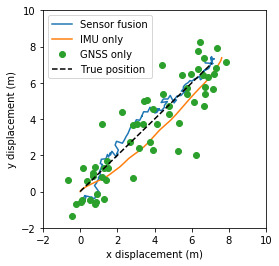

In [169]:
plt.figure(figsize=(4,4))

plt.plot(kalman_states[:, 0], kalman_states[:, 1], label='Sensor fusion')
plt.plot(no_updates[:, 0], no_updates[:, 1], label='IMU only')
plt.plot(sensor_position[:, 0], sensor_position[:, 1], 'o', label='GNSS only')
plt.plot(position_2d[:, 0], position_2d[:, 1], label='True position', ls='dashed', color='black')
plt.legend(loc='best')

plt.xlabel('x displacement (m)')
plt.ylabel('y displacement (m)')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.savefig('images/position-with-initial-estimate-right.png', dpi=300)

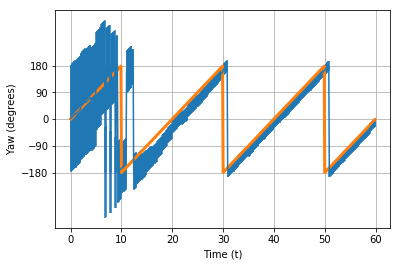

In [170]:
plt.errorbar(t, *np.degrees((np.mod(np.pi+kalman_states[:,4], np.pi*2) - np.pi, kalman_errors[:, 4])), label='Sensor fusion')
plt.plot(t, np.degrees(true_yaw), lw=3, label='True yaw')
plt.yticks((-180, -90, 0, 90, 180))
plt.xlabel('Time (t)')
plt.ylabel('Yaw (degrees)')
plt.grid()
plt.savefig('images/yaw-with-large-initial-estimate-right.png', dpi=300)

In [192]:
Q_pos = 0
Q_vel = .1
Q_ang = 1

number_of_states = 5

Q = np.array([
    [ACCELEROMETER_RMS_ERROR*dt**2/2, 0, 0, 0, 0,],
    [0, ACCELEROMETER_RMS_ERROR*dt**2/2, 0, 0, 0,],    
    [0, 0, ACCELEROMETER_RMS_ERROR*dt, 0, 0,],
    [0, 0, 0, ACCELEROMETER_RMS_ERROR*dt, 0,],
    [0, 0, 0, 0, GYRO_RMS_ERROR*dt,], 
]) ** 2

H = np.array([
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
])

R = np.array([
    [GPS_RMS_ERROR, 0],
    [0, GPS_RMS_ERROR],
]) ** 2    

kalman_states = np.empty((number_of_timesteps, number_of_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_states)) * np.nan

I = np.identity(number_of_states)

# initialize state
mu = np.array([0, 0, 0, 0, np.pi/2]).astype(float)
P = np.array([
    [GPS_RMS_ERROR, 0, 0,  0, 0,],
    [0, GPS_RMS_ERROR, 0,  0, 0,],
    [0, 0, ACCELEROMETER_RMS_ERROR*dt, 0, 0,],
    [0, 0, 0, ACCELEROMETER_RMS_ERROR*dt, 0,],
    [0, 0, 0, 0, np.pi,],
])**2
for time_index in range(number_of_timesteps):
    # Kalman step
   
    def f(mu, u):
        
        #rX, rX, rX, _, _, _, vZ, yaw, pitch, roll = mu 
        
        aX, aY, dyaw = u
        rx, ry, vx, vy, yaw = mu
        ca = np.cos(yaw + dyaw / 2)
        sa = np.sin(yaw + dyaw / 2)
        a = np.array([[ca, sa], [-sa, ca]]) @ np.array([aX, aY])
        ax, ay = a
        
        # Update based on velocity
        rx += vx * dt + ax * dt**2
        ry += vy * dt + ay * dt**2
        vx += ax * dt
        vy += ay * dt
        yaw += dyaw * dt

        # Update with sensor input
        return np.array([rx, ry, vx, vy, yaw])
    
    rx, ry, vx, vy, yaw = mu
    ca = np.cos(yaw)
    sa = np.sin(yaw)
    
    u = *sensor_accelerometer[time_index], sensor_gyro[time_index]
    aX, aY = sensor_accelerometer[time_index]
    
    F = np.array([
        [1, 0, dt, 0, 0],
        [0, 1, 0, dt, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1,],
    ])   
    
    F = np.array([
        [1, 0, dt, 0, -sa*aX*dt**2/2 + ca*aY*dt**2/2],
        [0, 1, 0, dt, -ca*aX*dt**2/2 - sa*aY*dt**2/2],
        [0, 0, 1, 0, -sa*aX*dt + ca*aY*dt],
        [0, 0, 0, 1, -ca*aX*dt - sa*aY*dt],
        [0, 0, 0, 0, 1,],
    ])     
    
      
    
    z = sensor_position[time_index, 0:2]
    
    # Predict
    mu = f(mu, u)
    P = F @ P @ F.T + Q

    use_gnss = False
    
    # If we have valid data
    if use_gnss and ~np.any(np.isnan(z)):
    # Update
        y = z - H @ mu # pre-fit residual
        K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
        mu = mu + K @ y
        P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
        y = z - H @ mu # post-fit residual

    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5
    
if not use_gnss:
    no_updates = kalman_states.copy()

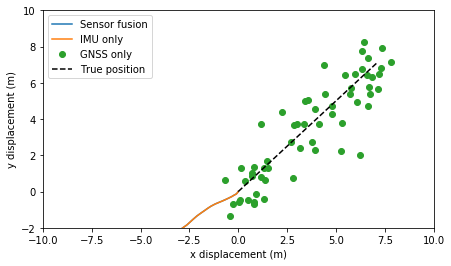

In [193]:
plt.figure(figsize=(7,4))

plt.plot(kalman_states[:, 0], kalman_states[:, 1], label='Sensor fusion')
plt.plot(no_updates[:, 0], no_updates[:, 1], label='IMU only')
plt.plot(sensor_position[:, 0], sensor_position[:, 1], 'o', label='GNSS only')
plt.plot(position_2d[:, 0], position_2d[:, 1], label='True position', ls='dashed', color='black')
plt.legend(loc='best')

plt.xlabel('x displacement (m)')
plt.ylabel('y displacement (m)')
plt.xlim(-10, 10)
plt.ylim(-2, 10)
plt.savefig('images/position-with-initial-estimate-wrong2.png', dpi=300)

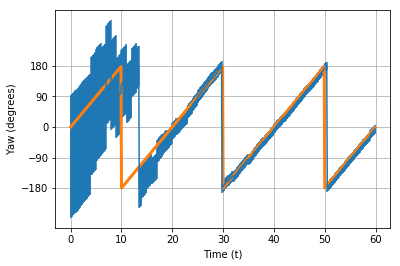

In [176]:
plt.errorbar(t, *np.degrees((np.mod(np.pi+kalman_states[:,4], np.pi*2) - np.pi, kalman_errors[:, 4])), label='Sensor fusion')
plt.plot(t, np.degrees(true_yaw), lw=3, label='True yaw')
plt.yticks((-180, -90, 0, 90, 180))
plt.xlabel('Time (t)')
plt.ylabel('Yaw (degrees)')
plt.grid()
plt.savefig('images/yaw-with-large-initial-estimate-wrong.png', dpi=300)

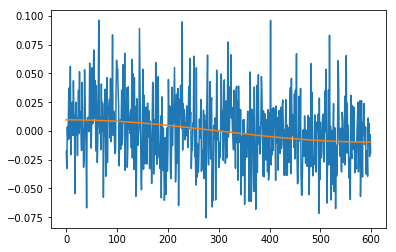

In [160]:
plt.plot(
    sensor_accelerometer[:,0] * np.cos(true_yaw) +
     sensor_accelerometer[:,1] * np.sin(true_yaw)
        )
plt.plot(acceleration_2d[:,0])

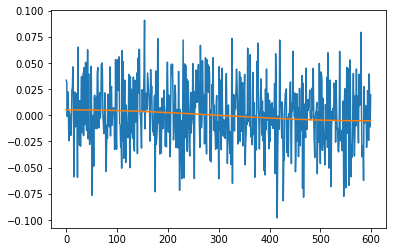

In [16]:
plt.plot(
    - sensor_accelerometer[:,0] * np.sin(true_yaw)
    + sensor_accelerometer[:,1] * np.cos(true_yaw)
        )
plt.plot(acceleration_2d[:,1])

In [22]:
Q_pos = 0
Q_vel = .1
Q_ang = 1

number_of_states = 9

Q = np.array([
    [GYRO_RMS_ERROR*dt,0,0, 0,0,0, 0,0,0],
    [0,GYRO_RMS_ERROR*dt,0, 0,0,0, 0,0,0],    
    [0,0,GYRO_RMS_ERROR*dt, 0,0,0, 0,0,0],
    [0,0,0, 0,0,0, 0,0,0],
    [0,0,0, 0,0,0, 0,0,0],
    [0,0,0, 0,0,0, 0,0,0],
    [0,0,0, 0,0,0, ACCELEROMETER_RMS_ERROR*dt,0,0,],
    [0,0,0, 0,0,0, 0,ACCELEROMETER_RMS_ERROR*dt,0,],
    [0,0,0, 0,0,0, 0,0,ACCELEROMETER_RMS_ERROR*dt,]
]) ** 2

H = np.array([
    [0,0,0, 1,0,0, 0,0,0],
    [0,0,0, 0,1,0, 0,0,0],
])

R = np.array([
    [GPS_RMS_ERROR, 0],
    [0, GPS_RMS_ERROR],
]) ** 2    

kalman_states = np.empty((number_of_timesteps, number_of_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_states)) * np.nan

I = np.identity(number_of_states)

# initialize state
mu = np.array([np.pi/2,0,0, 0,0,0, 0,0,0,]).astype(float)
P = np.array([
    [GYRO_RMS_ERROR*dt,0,0, 0,0,0, 0,0,0],
    [0,GYRO_RMS_ERROR*dt,0, 0,0,0, 0,0,0],    
    [0,0,GYRO_RMS_ERROR*dt, 0,0,0, 0,0,0],
    [0,0,0, 0,0,0, 0,0,0],
    [0,0,0, 0,0,0, 0,0,0],
    [0,0,0, 0,0,0, 0,0,0],
    [0,0,0, 0,0,0, ACCELEROMETER_RMS_ERROR*dt,0,0,],
    [0,0,0, 0,0,0, 0,ACCELEROMETER_RMS_ERROR*dt,0,],
    [0,0,0, 0,0,0, 0,0,ACCELEROMETER_RMS_ERROR*dt,]
]) ** 2

for time_index in range(number_of_timesteps):
    # Kalman step
   
    def f(mu, u):
        
        #rX, rX, rX, _, _, _, vZ, yaw, pitch, roll = mu 
        
        aX, aY, dyaw = u
        yaw, pitch, roll, rx, ry, rz, vx, vy, vz = mu
        yaw = yaw
        ca = np.cos(yaw + dyaw/2)
        sa = np.sin(yaw + dyaw/2)
        a = np.array([[ca, sa], [-sa, ca]]) @ np.array([aX, aY])
        ax, ay = a
        
        # Update based on velocity
        rx += vx * dt + ax * dt**2
        ry += vy * dt + ay * dt**2
        vx += ax * dt
        vy += ay * dt
        yaw += dyaw * dt

        # Update with sensor input
        return np.array([yaw, pitch, roll, rx, ry, rz, vx, vy, vz])
    
    yaw, pitch, roll, rx, ry, rz, vx, vy, vz = mu
    ca = np.cos(yaw)
    sa = np.sin(yaw)
    
    u = *sensor_accelerometer[time_index], sensor_gyro[time_index]
    aX, aY = sensor_accelerometer[time_index]
    aZ = 0
    
    ca = np.cos(yaw)
    sa = np.sin(yaw)
    cb = np.cos(pitch)
    sb = np.sin(pitch)
    sg = np.sin(roll)
    cg = np.cos(roll)
    
    daxda = ((-sa*cg-ca*sb*sg)*aX + (-cb*ca) * aY + (ca*sb*cg - sa*sg) * aZ)
    dayda = ((ca*cg-sa*sb*sg) *aX + (-sa*cb) * aY + (sa*sb*cg + ca*sg) * aZ)
    dazda = (0) 
    
    daxdb = -sa * cb*sg * aX + sb*sa * aY  +sa*cb*cg * aZ
    daydb =    ca*cb*sg * aX  -ca*sb * aY  -ca*cg*cb * aZ
    dazdb =       sb*sg * aX    + cb * aY     -sb*cg * aZ
    
    daxdg = (-ca*sg - sa*sb*cg) * aX * 0*aY +  (-sa*sb*sg+ca*cg) * aZ
    daydg =   (-sa*sg+ca*sb*cg) * aX + 0*aY + (ca*sb*sg + sa*cg) * aZ
    dazdg =            (-cb*cg) * aX + 0*aY              - cb*sg * aZ
    
    F = np.array([
        [1, 0, 0,  0, 0, 0,  0, 0, 0], #(-vx*sa-sgn*ca*vy), (sgn*vx*ca-sa*vy), 0],
        [0, 1, 0,  0, 0, 0,  0, 0, 0],
        [0, 0, 1,  0, 0, 0,  0, 0, 0],
        
        [daxda*dt**2/2, daxdb*dt**2/2, daxdg*dt**2/2,  1, 0, 0,  dt, 0, 0],
        [dayda*dt**2/2, daydb*dt**2/2, daydg*dt**2/2,  0, 1, 0,  0, dt, 0],
        [dazda*dt**2/2, dazdb*dt**2/2, dazdg*dt**2/2,  0, 0, 1,  0, 0, dt],
        
        [daxda*dt, daxdb*dt, daxdg*dt,  0, 0, 0,  1, 0, 0],
        [dayda*dt, daydb*dt, daydg*dt,  0, 0, 0,  0, 1, 0],
        [dazda*dt, dazdb*dt, dazdg*dt,  0, 0, 0,  0, 0, 1]
    ])
    
    z = sensor_position[time_index, 0:2]

    #print(z)

    # Predict
    mu = f(mu, u)
    P = F @ P @ F.T + Q

    # Update
    y = z - H @ mu # pre-fit residual
    K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    mu = mu + K @ y
    P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
    y = z - H @ mu # post-fit residual

    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5

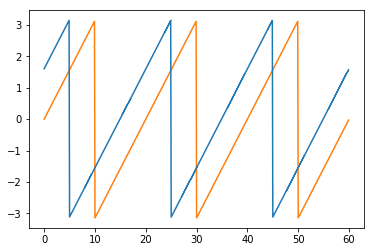

In [23]:
plt.errorbar(t, np.mod(np.pi+kalman_states[:,0], np.pi*2) - np.pi, kalman_errors[:, 0])
plt.plot(t, true_yaw)

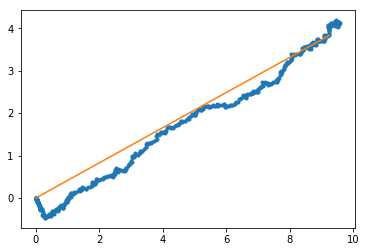

In [24]:
plt.plot(kalman_states[:, 3], kalman_states[:, 4], '.')
plt.plot(position_2d[:, 0], position_2d[:, 1])

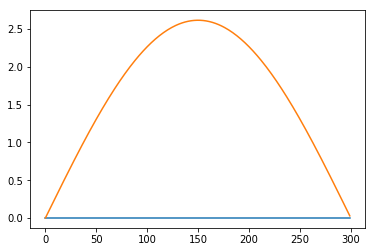

In [349]:
plt.plot(sensor_accelerometer[:,0])
plt.plot(true_velocity)

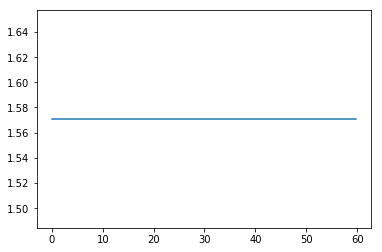

In [126]:
plt.plot(t, np.mod(kalman_states[:, 4] + np.pi, 2*np.pi) - np.pi, '-')

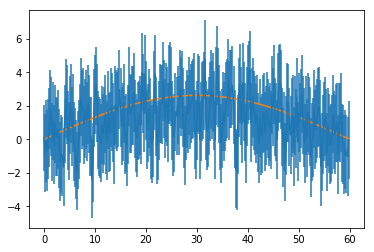

In [116]:
idx = 2
plt.errorbar(t, kalman_states[:, idx], kalman_errors[:, idx])
plt.plot(t, true_velocity)

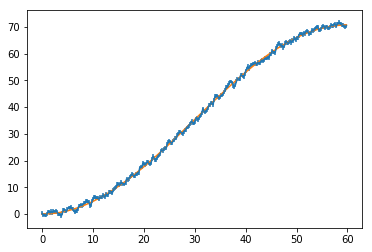

In [92]:
idx = 0
plt.errorbar(t, kalman_states[:, idx], kalman_errors[:, idx])
plt.plot(t, position_2d[:, 0])

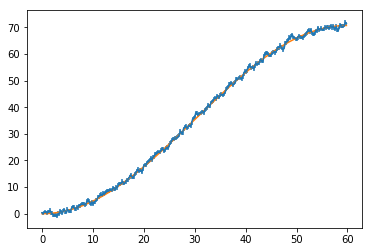

In [73]:
idx = 1
plt.errorbar(t, kalman_states[:, idx], kalman_errors[:, idx])
plt.plot(t, position_2d[:, 1])

<ErrorbarContainer object of 3 artists>

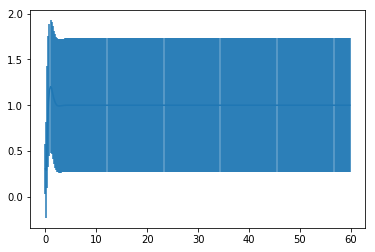

In [74]:
idx = 2
plt.errorbar(t, kalman_states[:, idx], kalman_errors[:, idx])
#plt.plot(t, position_2d[:, 1])

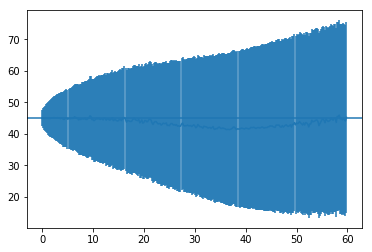

In [75]:
idx = 6
plt.errorbar(t, kalman_states[:, idx]*180/np.pi, kalman_errors[:, idx]*180/np.pi)
plt.axhline(angle*180/np.pi)
#plt.plot(t, position_2d[:, 1])

In [783]:
F = np.array([
    [1, dt],
    [0, 1],
])

Q_pos = .0001
Q_vel = .00001

Q = np.array([
    [Q_pos, 0],
    [0, Q_vel],
])



H = np.array([
    [1, 0],
])


In [687]:
def get_l2_norm_for_Q(Q_pos, Q_vel):
    
    Q = np.array([
        [Q_pos, 0],
        [0, Q_vel],
    ])    

    R = np.array([
        [GPS_RMS_ERROR, ]
    ]) ** 2    
    
    kalman_states = np.empty((number_of_timesteps, 2)) * np.nan
    kalman_errors = np.empty((number_of_timesteps, 2)) * np.nan

    I = np.identity(2)

    # initialize state
    mu = np.array([0, 0])
    P = np.array([
        [GPS_RMS_ERROR**2, 0],
        [0, 0],
    ])
    for time_index in range(number_of_timesteps):
        # Kalman step

        z = np.array([sensor_position[time_index]])

        #print(z)

        # Predict
        mu_model = F @ mu
        P = F @ P @ F.T + Q

        # Update
        y = z - H @ mu_model # pre-fit residual
        K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
        #print(time_index, K)
        mu = mu_model + K @ y
        P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
        y = z - H @ mu # post-fit residual



        kalman_states[time_index,:] = mu
        kalman_errors[time_index,:] = P.diagonal()**.5

    residual = kalman_states[:,0] - true_position
        
    l2_norm = np.sum(residual**2) / number_of_timesteps
    return l2_norm ** .5 

In [9]:
TOTAL_DISTANCE = 100 # meters 

TOTAL_SECONDS = 60 # seconds
SAMPLING_RATE = 10  # Hz
dt = 1 / SAMPLING_RATE

GPS_RMS_ERROR = GPS_error
number_of_timesteps = TOTAL_SECONDS * SAMPLING_RATE
t = np.arange(number_of_timesteps) / SAMPLING_RATE

true_position = TOTAL_DISTANCE * ( 1 - np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS))) / 2
true_velocity = TOTAL_DISTANCE / 2 * np.sin(2 * np.pi * t / (2 * TOTAL_SECONDS) ) * (2 * np.pi / (2 * TOTAL_SECONDS))

np.random.seed(52) 
sensor_position = true_position + np.random.randn(number_of_timesteps) * GPS_RMS_ERROR    

Q = np.array([
    [0, 0],
    [0, .0001],
])    

R = np.array([
    [GPS_RMS_ERROR, ]
]) ** 2    

kalman_states = np.empty((number_of_timesteps, 2)) * np.nan
kalman_errors = np.empty((number_of_timesteps, 2)) * np.nan

I = np.identity(2)

# initialize state
mu = np.array([0, 0])
P = np.array([
    [GPS_RMS_ERROR**2, 0],
    [0, 0],
])
for time_index in range(number_of_timesteps):
    # Kalman step

    z = np.array([sensor_position[time_index]])

    #print(z)

    # Predict
    mu_model = F @ mu
    P = F @ P @ F.T + Q

    # Update
    y = z - H @ mu_model # pre-fit residual
    K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    #print(time_index, K)
    mu = mu_model + K @ y
    P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
    y = z - H @ mu # post-fit residual



    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5
    
    
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(t, kalman_states[:, 0])
ax1.plot(t, true_position)

ax2.plot(t, kalman_states[:, 1])
ax2.plot(t, true_velocity * dt)

NameError: name 'GPS_error' is not defined

In [142]:
Q_pos_arr = np.logspace(-8, 2, 10)
Q_vel_arr = np.logspace(-8, 1, 10)

In [143]:
Qs = np.meshgrid(Q_pos_arr, Q_vel_arr)[0]

In [144]:
l2_norms = np.empty(Qs.shape)
l2_norms[:, :] = np.nan

In [145]:
for row, Q_pos in enumerate(Q_pos_arr):
    for col, Q_vel in enumerate(Q_vel_arr):
        l2_norms[row, col] = get_l2_norm_for_Q(Q_pos, Q_vel)

Text(0.5, 0, 'Q_vel')

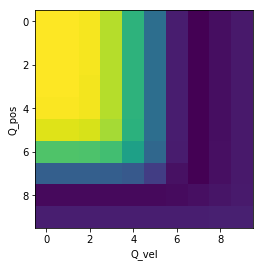

In [146]:
plt.imshow(np.log10(l2_norms))
plt.ylabel('Q_pos')
plt.xlabel('Q_vel')

Text(0.5, 0, '$Q_{vel}$ $(m/s)^2$')

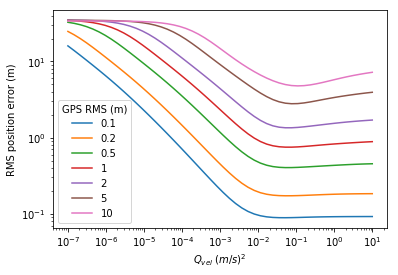

In [187]:
for GPS_error in [.1, .2, .5, 1, 2, 5, 10]: 
    TOTAL_DISTANCE = 100 # meters 

    TOTAL_SECONDS = 60 # seconds
    SAMPLING_RATE = 1  # Hz
    dt = 1 / SAMPLING_RATE

    GPS_RMS_ERROR = GPS_error
    number_of_timesteps = TOTAL_SECONDS * SAMPLING_RATE
    t = np.arange(number_of_timesteps) / SAMPLING_RATE
        
    true_position = TOTAL_DISTANCE * ( 1 - np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS))) / 2
    np.random.seed(52) 
    sensor_position = true_position + np.random.randn(number_of_timesteps) * GPS_RMS_ERROR    

    
    Q_vel_list = np.logspace(-7, 1)
    l2_norm_list = np.array([get_l2_norm_for_Q(0, Q_vel) for Q_vel in Q_vel_list])

    plt.loglog(Q_vel_list, l2_norm_list, label=GPS_error)
plt.legend(loc='best', title=('GPS RMS (m)'))
plt.ylabel('RMS position error (m)')
plt.xlabel(r'$Q_{vel}$ $(m/s)^2$')

array([-0.46179356, -0.12621527,  0.15325446, -0.15956678])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


Text(0.5, 0, '$Q_{vel}$ $(m/s)^2$')

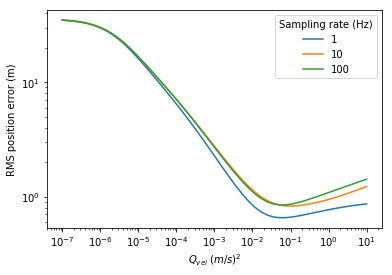

In [222]:

for sampling_rate in [1, 10, 100]: 
    TOTAL_DISTANCE = 100 # meters 

    TOTAL_SECONDS = 60 # seconds
    SAMPLING_RATE = sampling_rate #1  # Hz
    dt = 1 / SAMPLING_RATE

    GPS_RMS_ERROR = 1 #* SAMPLING_RATE **.5
    number_of_timesteps = TOTAL_SECONDS * SAMPLING_RATE
    t = np.arange(number_of_timesteps) / SAMPLING_RATE
    true_position = TOTAL_DISTANCE * ( 1 - np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS))) / 2
    np.random.seed(52) 
    sensor_noise_raw = np.random.randn(TOTAL_SECONDS * 100) * GPS_RMS_ERROR * 100**.5
    sensor_noise_downsampled = np.mean(
        sensor_noise_raw.reshape(-1 , number_of_timesteps), 
        axis=0)
    sensor_position = true_position + sensor_noise_downsampled

    Q_vel_list = np.logspace(-7, 1)
    l2_norm_list = np.array([get_l2_norm_for_Q(0, Q_vel / sampling_rate**4) for Q_vel in Q_vel_list])

    plt.loglog(Q_vel_list, l2_norm_list, label=sampling_rate)
plt.legend(loc='best', title=('Sampling rate (Hz)'))
plt.ylabel('RMS position error (m)')
plt.xlabel(r'$Q_{vel}$ $(m/s)^2$')

Text(0.5, 0, '$Q_{vel}$ $(m/s)^2$')

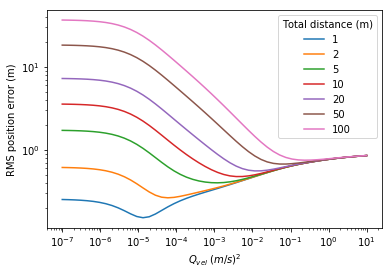

In [177]:
for TOTAL_DISTANCE in [1, 2, 5, 10, 20, 50, 100]:
    #TOTAL_DISTANCE = 100 # meters 

    TOTAL_SECONDS = 60 # seconds
    SAMPLING_RATE = 1  # Hz
    dt = 1 / SAMPLING_RATE

    GPS_RMS_ERROR = 1 * SAMPLING_RATE ** .5
    number_of_timesteps = TOTAL_SECONDS * SAMPLING_RATE
    t = np.arange(number_of_timesteps) / SAMPLING_RATE
    true_position = TOTAL_DISTANCE * ( 1 - np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS))) / 2
    np.random.seed(52) 
    sensor_position = true_position + np.random.randn(number_of_timesteps) * GPS_RMS_ERROR    

    
    Q_vel_list = np.logspace(-7, 1)
    l2_norm_list = np.array([get_l2_norm_for_Q(0, Q_vel) for Q_vel in Q_vel_list])

    plt.loglog(Q_vel_list, l2_norm_list, label=TOTAL_DISTANCE)
plt.legend(loc='best', title=('Total distance (m)'))
plt.ylabel('RMS position error (m)')
plt.xlabel(r'$Q_{vel}$ $(m/s)^2$')

Text(0.5, 1.0, 'GPS error scaled as percentage of position variation')

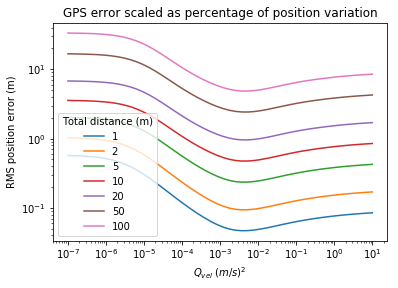

In [179]:
for TOTAL_DISTANCE in [1, 2, 5, 10, 20, 50, 100]:
    #TOTAL_DISTANCE = 100 # meters 

    TOTAL_SECONDS = 60 # seconds
    SAMPLING_RATE = 1  # Hz
    dt = 1 / SAMPLING_RATE

    GPS_RMS_ERROR = .1 * TOTAL_DISTANCE * SAMPLING_RATE ** .5
    number_of_timesteps = TOTAL_SECONDS * SAMPLING_RATE
    t = np.arange(number_of_timesteps) / SAMPLING_RATE
    true_position = TOTAL_DISTANCE * ( 1 - np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS))) / 2
    np.random.seed(52) 
    sensor_position = true_position + np.random.randn(number_of_timesteps) * GPS_RMS_ERROR    

    
    Q_vel_list = np.logspace(-7, 1)
    l2_norm_list = np.array([get_l2_norm_for_Q(0, Q_vel) for Q_vel in Q_vel_list])

    plt.loglog(Q_vel_list, l2_norm_list, label=TOTAL_DISTANCE)
plt.legend(loc='best', title=('Total distance (m)'))
plt.ylabel('RMS position error (m)')
plt.xlabel(r'$Q_{vel}$ $(m/s)^2$')
plt.title('GPS error scaled as percentage of position variation')

In [47]:
get_l2_norm_for_Q(.01, .001)

61.99467572122603

In [44]:
#kalman_index = 0
#plt.errorbar(t, (kalman_states[:, kalman_index]), kalman_errors[:, kalman_index])
#plt.plot(t, true_position)

In [38]:
residual = kalman_states[:, 0] - true_position

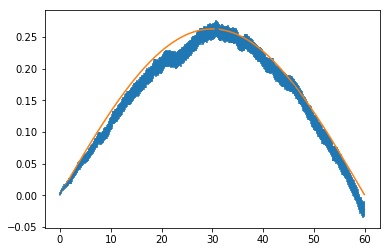

In [23]:
kalman_index = 1
plt.errorbar(t, (kalman_states[:, kalman_index]), kalman_errors[:, kalman_index])
plt.plot(t, np.cumsum(true_acceleration) * dt)

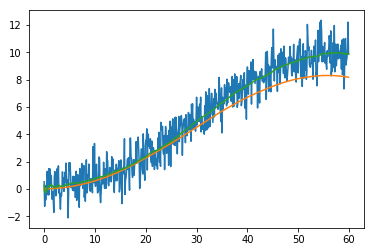

In [24]:
plt.plot(t, position_estimate_gps_only)
plt.plot(t, position_estimate_accelerometer_only)
plt.plot(t, kalman_states[:, 0])

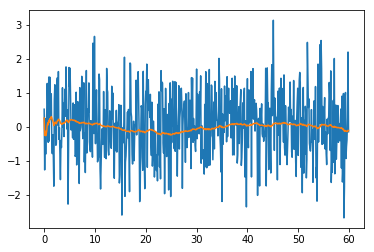

In [25]:
plt.plot(t, position_estimate_gps_only - true_position)
plt.plot(t, kalman_states[:, 0] - true_position)
#plt.plot(t, kalman_states[:, 0])